In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10340092023221013235,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2165361581028599733
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14511556849579950632
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17041772785806161611
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1737717615986599904
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2565296446454808648
 physical_device_desc: "device: XLA_GPU device"]

## Load the packages and check the keras datasets

In [2]:
import numpy as np
from tqdm import trange
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# First we load the dataset and take care of the shape
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)

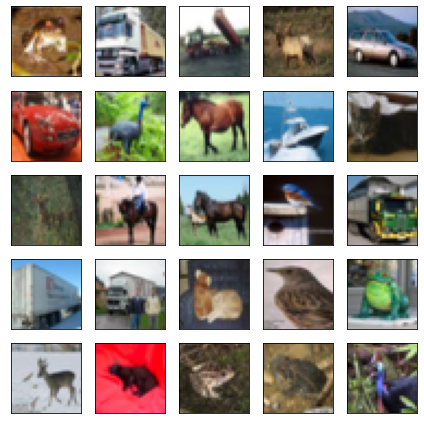

In [4]:
# Get a sample visual of the CIFAR10
fig = plt.figure(figsize=(6,6))
for i in range(0, 25):
    plt.subplot(5, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
plt.tight_layout()

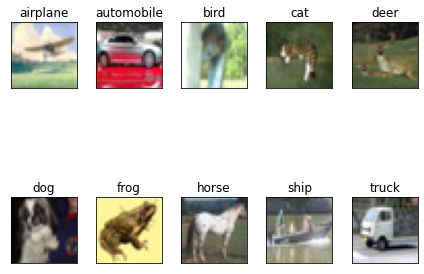

In [5]:
# Get a first visual of all the classes
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(6,6))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
plt.tight_layout()

In [6]:
# Check the shape and training samples
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('{} train samples'.format(X_train.shape[0]))
print('{} test samples'.format(X_test.shape[0]))

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# Let all the data between -1 and 1 to fit the tanh activation
X_train = np.float32(X_train)
X_test = np.float32(X_test)
X_train = (X_train / 255 - 0.5) * 2
X_test = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)
X_test = np.clip(X_test, -1, 1)
print('X_train reshape: {}'.format(X_train.shape))
print('X_test reshape: {}'.format(X_test.shape))

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


## Define our generator model

In [8]:
# define the latent dimension
latent_dim = 100

In [9]:
def buildGeneratorModel():
    model = Sequential()
    model.add(Dense(2 * 2 * 512, input_shape=(latent_dim,), kernel_initializer=initializers.RandomNormal(stddev=0.05)))
    model.add(Reshape((2, 2, 512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))
    return model

In [10]:
generator=buildGeneratorModel()
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         6554112   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 512)         0

## Define our discriminator model

In [11]:
def buildDiscriminatorModel():
    model = Sequential()
    model.add(
        Conv2D(64, 5, 2, 'same', input_shape=(32, 32, 3), kernel_initializer=initializers.RandomNormal(stddev=0.05)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2D(128, 5, 2, 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2D(256, 5, 2, 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Conv2D(512, 5, 2, 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.25))

    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
discriminator=buildDiscriminatorModel()
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

## Compile Everything and get our DCGAN summary

In [13]:
discriminator.compile(Adam(lr=0.0005, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
discriminator.trainable = False
generator_input = Input(shape=(latent_dim,))
image = generator(generator_input)
result = discriminator(image)
dcgan = Model(inputs=generator_input, outputs=result)
dcgan.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
print(dcgan.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         10457859  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4312449   
Total params: 14,770,308
Trainable params: 10,455,171
Non-trainable params: 4,315,137
_________________________________________________________________
None


## Train the model

In [18]:
# define some variables and training detail
epochs = 100
batch_size = 1024
smooth = 0.15
batches = len(X_train) // batch_size
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
d_loss, g_loss = [], []

100%|██████████| 48/48 [09:26<00:00, 11.80s/it]


epoch 1/100: d_loss = 0.2133422968618106, g_loss = 0.007595003582537174



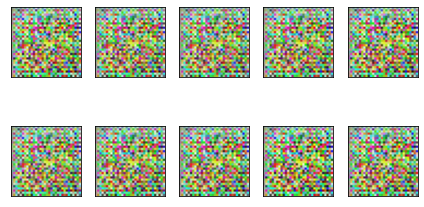

 46%|████▌     | 22/48 [04:18<05:05, 11.75s/it]

In [ ]:
# train the model and print training detail every ten epochs
for e in range(epochs + 1):
    for i in trange(len(X_train) // batch_size):
        # train the discriminator weights
        discriminator.trainable = True

        # real samples
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        # fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # calculate discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # train the generator weights
        discriminator.trainable = False
        g_loss_batch = dcgan.train_on_batch(x=z, y=real)

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])

    if e % 10 == 0:
        print("epoch {}/{}: d_loss = {}, g_loss = {}\n".format(e + 1, epochs, d_loss[-1], g_loss[-1]))
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1) * 127).astype(np.uint8))
        plt.tight_layout()
        plt.show()

## Plot the loss through the training process

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()